<a href="https://colab.research.google.com/github/omerhac/OSIC/blob/master/OSIC_starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import numpy as np
import math
import os
import pandas as pd
import tensorflow as tf
import glob
import seaborn as sns
AUTO = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install gcsfs

# Get files paths

In [3]:
GCS_PATH = 'gs://kds-2150a8452c62b1b8edc84199c9e1f6e47811129e97076f025124c694'
IMAGES_GCS_PATH = 'gs://osic_fibrosis/images'

In [4]:
!gsutil ls 'gs://osic_fibrosis/images'

gs://osic_fibrosis/images/.DS_Store
gs://osic_fibrosis/images/test/
gs://osic_fibrosis/images/train/


In [5]:
%%time
# build datasets with filepaths of images
train_paths = tf.data.Dataset.list_files(IMAGES_GCS_PATH + '/train/*/*', shuffle=True)
test_paths = tf.data.Dataset.list_files(IMAGES_GCS_PATH + '/test/*/*', shuffle=True)

CPU times: user 470 ms, sys: 58.9 ms, total: 529 ms
Wall time: 42.1 s


In [6]:
%%time
def read_image(image_path):
  """ Reads a jpeg image from image_path """
  image_bytes = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image_bytes)

  # resize
  #resized_image = tf.image.resize(image, (512, 512))
  
  return image

# get a datalist of images
train_images = train_paths.map(read_image, num_parallel_calls=AUTO)
test_images = test_paths.map(read_image, num_parallel_calls=AUTO)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function read_image at 0x7f0c02f89ae8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function read_image at 0x7f0c02f89ae8>. Note that functions defined in certain environments, like the interactive Python shell d

# Plotting utils


In [7]:
def show_scans(scans_dataset, n_scans):
  """ Show #n_scans# scans from #scans_dataset# """

  # def plot
  fig, ax = plt.subplots(1, n_scans, figsize=(8 * n_scans ,8))

  # loop threw n_scans
  for i, scan in enumerate(scans_dataset.take(n_scans)):
    ax[i].imshow(scan)


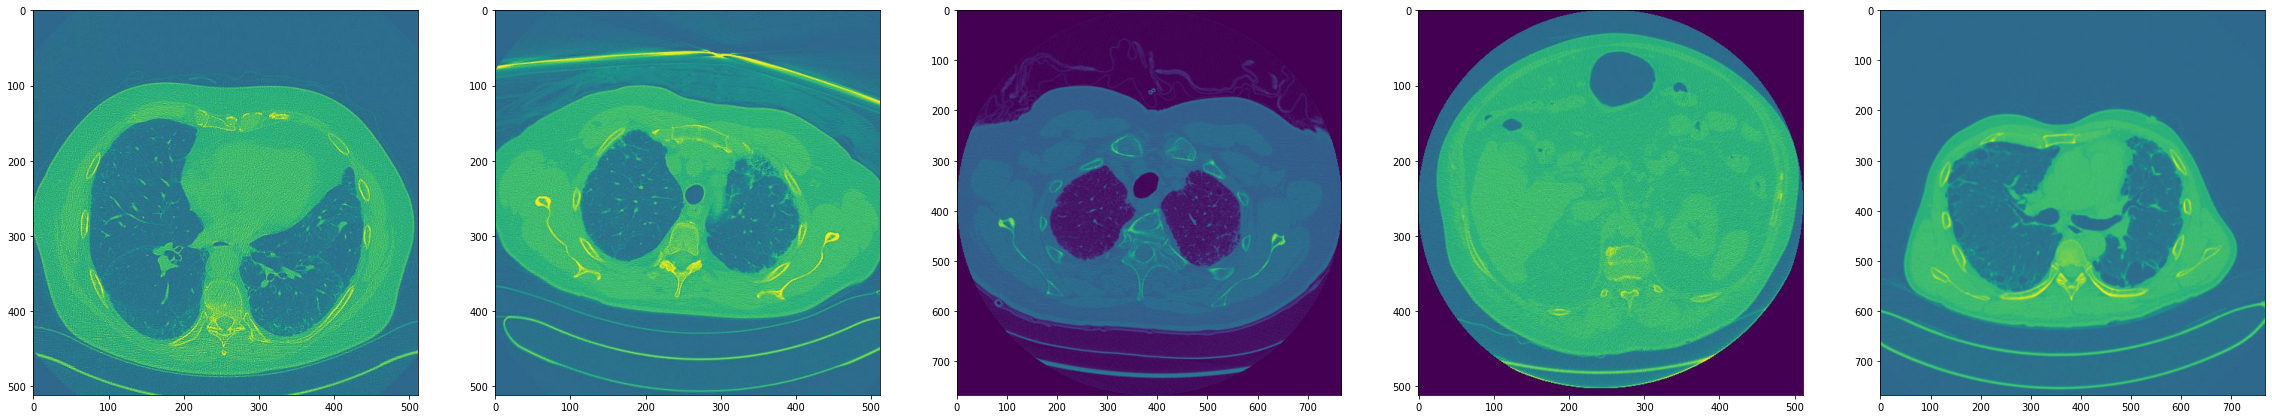

In [8]:
show_scans(train_images, 5)

# Scans utilities


In [9]:
def get_scans_by_id(root_path, id):
  """ Returns a dataset with all the scans of #id# at #root_path# """
  
  # create paths dataset
  paths = tf.data.Dataset.list_files(root_path + '/' + id + '/*')

  return paths.map(read_image, num_parallel_calls=AUTO)

# Table data loading and EDA

In [35]:
# load csvs
train_table = pd.read_csv(GCS_PATH + '/train.csv')
test_table = pd.read_csv(GCS_PATH + '/test.csv')

In [11]:
### EDA utils
def get_fvc_hist(table, id):
  """ Returns the FVC hist of a patient wit ID #id# from #table# """

  id_table = table[table["Patient"] == id].sort_values("Weeks")

  return id_table[["Weeks", "FVC"]]


def plot_fvc_hist(table, id):
  """ Plots the FVC hist of a patient with ID #id# from #table# """

  plt.figure(figsize=(8,8))
  
  # get hist
  hist = get_fvc_hist(table, id)

  # plot
  plt.plot(hist["Weeks"], hist["FVC"])
  plt.ylabel('FVC')
  plt.xlabel('Weeks')


def get_percent_hist(table, id):
  """ Returns the Percent hist of a patient wit ID #id# from #table# """

  id_table = table[table["Patient"] == id].sort_values("Percent")

  return id_table[["Weeks", "Percent"]]


def plot_percent_hist(table, id):
  """ Plots the Percent hist of a patient with ID #id# from #table# """

  plt.figure(figsize=(8,8))
  
  # get hist
  hist = get_percent_hist(table, id)

  # plot
  plt.plot(hist["Weeks"], hist["Percent"])
  plt.ylabel('Percent')
  plt.xlabel('Weeks')

In [12]:
train_table.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker


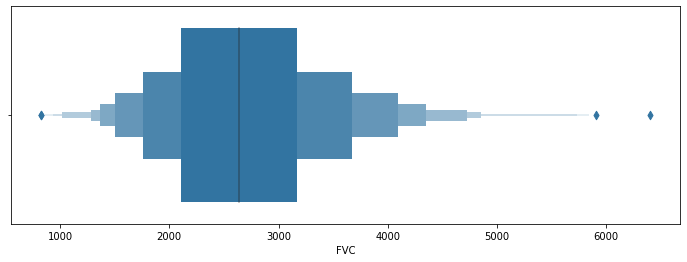

In [13]:
# plot FVC
plt.figure(figsize=(12,4))
sns.boxenplot(train_table["FVC"])

(array([ 36.,  97., 144., 220., 348., 357., 219.,  85.,  27.,  16.]),
 array([49. , 52.9, 56.8, 60.7, 64.6, 68.5, 72.4, 76.3, 80.2, 84.1, 88. ]),
 <a list of 10 Patch objects>)

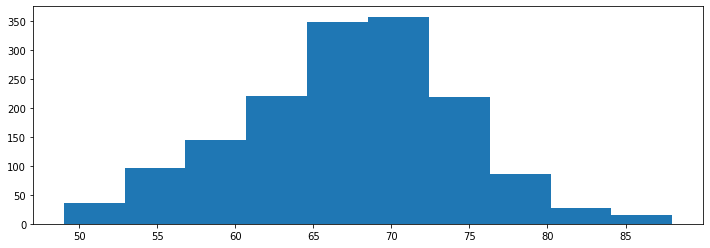

In [14]:
# plot Age
plt.figure(figsize=(12,4))
plt.hist(train_table["Age"])

(array([1224.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         325.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

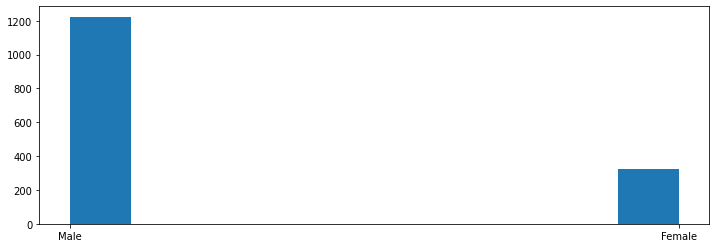

In [15]:
# plot Sex
plt.figure(figsize=(12,4))
plt.hist(train_table["Sex"])

(array([1038.,    0.,    0.,    0.,    0.,  429.,    0.,    0.,    0.,
          82.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

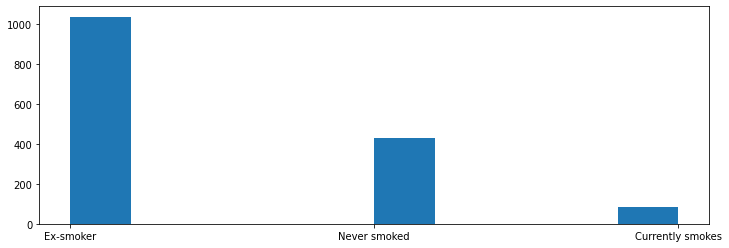

In [16]:
# plot SmokingStatus
plt.figure(figsize=(12,4))
plt.hist(train_table["SmokingStatus"])

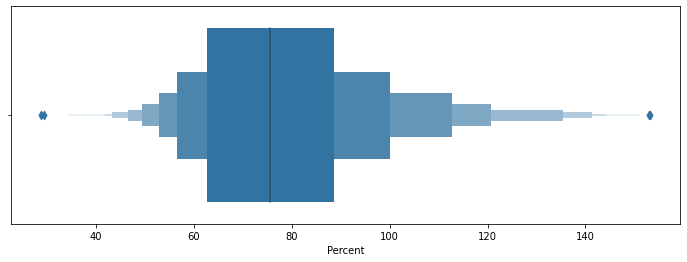

In [17]:
# plot Percent
plt.figure(figsize=(12,4))
sns.boxenplot(train_table["Percent"])

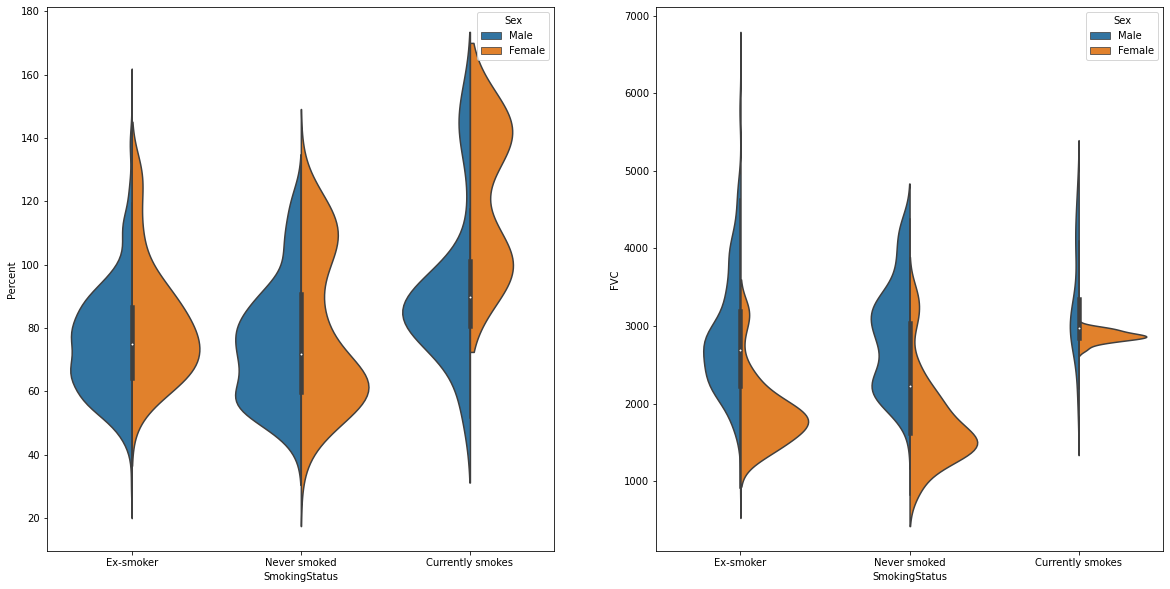

In [18]:
fix, ax = plt.subplots(1, 2, figsize=(20,10))

# plot Precent vs Smoker+Sex
#sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x=train_table['SmokingStatus'], y=train_table['Percent'], hue=train_table['Sex'], split=True, ax=ax[0])

# plot FVC vs Smoker+Sex
sns.violinplot(x=train_table['SmokingStatus'], y=train_table['FVC'], hue=train_table['Sex'], split=True, ax=ax[1])

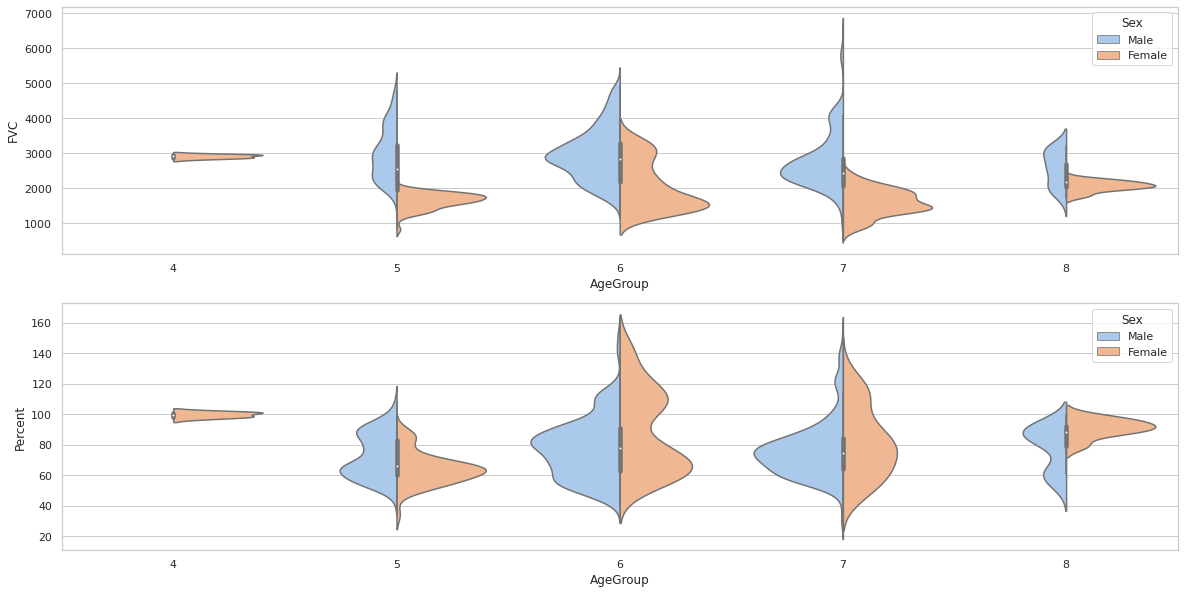

In [19]:
# Create age groups
train_table["AgeGroup"] = train_table["Age"] // 10
test_table["AgeGroup"] = test_table["Age"] // 10


sns.set(style="whitegrid", palette="pastel", color_codes=True)
fix, ax =plt.subplots(2,1, figsize=(20,10))

# plot Percent vs Age+Sex
sns.violinplot(x=train_table["AgeGroup"], y=train_table["Percent"], hue=train_table["Sex"], split=True, ax=ax[1])

# plot FVC vs Age+Sex
sns.violinplot(x=train_table["AgeGroup"], y=train_table["FVC"], hue=train_table["Sex"], split=True, ax=ax[0])


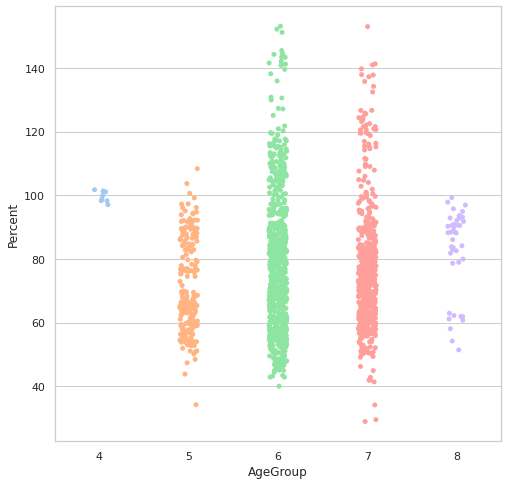

In [20]:
# plot female smokers Percent vs Age
plt.figure(figsize=(8,8))
sns.stripplot(x=train_table["AgeGroup"], y= train_table["Percent"], jitter=True)


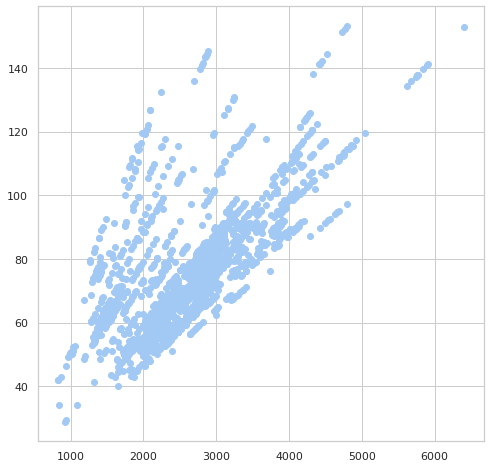

In [21]:
# plot Percent vs FVC
plt.figure(figsize=(8,8))
plt.scatter(train_table["FVC"], train_table["Percent"])

In [22]:
# some statistics
print(len(train_table) / len(train_table.groupby(["Patient"]))) # how many FVC entries on avarge per patient

8.801136363636363


# Baseline model

In [23]:
!git clone https://github.com/omerhac/Data-Science-Tools.git
%cd Data-Science-Tools

Cloning into 'Data-Science-Tools'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 6), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.
/content/Data-Science-Tools


In [24]:
from tabularized_data_utils import *

# data utils
def get_data_upto_chek_numebr(table, chek_number):
  """ Returns a table with data only upoto chek_number #chek_number# """

  return table[table["chek_number"] <= chek_number]

def get_check_number_column(df):
  """ Returns a column with the number of the FVC check per patient """

  table = df.copy()
  
  # add ones column for summing
  table["ones"] = 1

  # sort table
  table.sort_values(["Patient", "Weeks"])

  # get a count of rows uptill now
  count = df.groupby("Patient").size().cumsum() - df.groupby("Patient").size() # for every id count the rows up untill that id
  rows_so_far = table["Patient"].map(count) # get a mapping of id -> count

  # sum ones
  check_number = table["ones"].cumsum() - rows_so_far

  return check_number


def get_lag_features(df, lagged_features, shifts):
  """ Returns a dataframe with lagged features """

  lagged_df = df.copy()
  index_cols = ["Patient", "check_number"]

  for shift in shifts:
    # create lags
    lagged_cols = df[index_cols + lagged_features]
    lagged_cols["check_number"] = df["check_number"] + shift

    # rename
    rename = lambda col: "{}__lag__{}".format(col, shift) if col in lagged_features else col
    lagged_cols = lagged_cols.rename(columns=rename)

    # merge them
    lagged_df = lagged_df.merge(lagged_cols, on=index_cols, how='left')

  return lagged_df
  
  

In [36]:
# create check number feature
train_table["check_number"] = get_check_number_column(train_table)

# create lag features
train_table = get_lag_features(train_table, ["FVC", "Percent", "Weeks"], [1,2,3,4,5])

# fill nans
#train_table = replace_numeric_columns_nulls(train_table)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Prepare dataset

In [37]:
# mean encoder categorical features
encoded_train = mean_encode_categorical(train_table, "FVC")
encoded_train["check_number"] = train_table["check_number"] # reconstruct check number

# encode Patient column
ids_fact, ids = pd.factorize(encoded_train["Patient"])
ids_dict = {i: id for (i, id) in enumerate(ids)} # dict for later use
encoded_train["Patient"] = ids_fact

In [38]:
#encoded_train = encoded_train[encoded_train["check_number"] > 5] # remove old data

# train dataset
y_train = encoded_train.loc[encoded_train["check_number"] <= 7, "FVC"]
x_train = encoded_train[encoded_train["check_number"] <= 7].drop(["FVC"], axis=1)

# test dataset
y_test = encoded_train.loc[encoded_train["check_number"] > 7, "FVC"]
x_test = encoded_train[encoded_train["check_number"] > 7].drop(["FVC"], axis=1)


In [39]:
x_train

,Patient,Weeks,Percent,Age,Sex,SmokingStatus,check_number,FVC__lag__1,Percent__lag__1,Weeks__lag__1,FVC__lag__2,Percent__lag__2,Weeks__lag__2,FVC__lag__3,Percent__lag__3,Weeks__lag__3,FVC__lag__4,Percent__lag__4,Weeks__lag__4,FVC__lag__5,Percent__lag__5,Weeks__lag__5
0,0,-4,58.253649,2791.542782,2748.477321,2727.139300,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5,55.712129,2315.000000,2315.000000,2315.000000,2,2315.0,58.253649,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,7,51.862104,2264.500000,2264.500000,2264.500000,3,2214.0,55.712129,5.0,2315.0,58.253649,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,9,53.950679,2196.666667,2196.666667,2196.666667,4,2061.0,51.862104,7.0,2214.0,55.712129,5.0,2315.0,58.253649,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,11,52.063412,2183.500000,2183.500000,2183.500000,5,2144.0,53.950679,9.0,2061.0,51.862104,7.0,2214.0,55.712129,5.0,2315.0,58.253649,-4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,175,9,71.603968,2525.890110,2906.304848,2355.516588,3,2903.0,71.284746,7.0,2925.0,71.824968,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1543,175,11,73.077301,2530.130435,2906.312808,2356.841608,4,2916.0,71.603968,9.0,2903.0,71.284746,7.0,2925.0,71.824968,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1544,175,13,66.594637,2534.924731,2906.369975,2358.301887,5,2976.0,73.077301,11.0,2916.0,71.603968,9.0,2903.0,71.284746,7.0,2925.0,71.824968,0.0,NaN,NaN,NaN
1545,175,19,73.126412,2536.808511,2906.210656,2359.134118,6,2712.0,66.594637,13.0,2976.0,73.077301,11.0,2916.0,71.603968,9.0,2903.0,71.284746,7.0,2925.0,71.824968,0.0


## LGBM model

In [40]:
import lightgbm as lgb
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'early_stopping_rounds': 10,
               'verbose_eval': True
              }



model = lgb.train(lgb_params, lgb.Dataset(x_train, label=y_train), 2000, valid_sets=lgb.Dataset(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 821.672
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 786.664
[3]	valid_0's rmse: 756.63
[4]	valid_0's rmse: 732.377
[5]	valid_0's rmse: 705.41
[6]	valid_0's rmse: 676.891
[7]	valid_0's rmse: 650.976
[8]	valid_0's rmse: 625.564
[9]	valid_0's rmse: 603.706
[10]	valid_0's rmse: 582.943
[11]	valid_0's rmse: 562.993
[12]	valid_0's rmse: 546.507
[13]	valid_0's rmse: 526.595
[14]	valid_0's rmse: 507.854
[15]	valid_0's rmse: 491.682
[16]	valid_0's rmse: 474.825
[17]	valid_0's rmse: 459.268
[18]	valid_0's rmse: 445.115
[19]	valid_0's rmse: 431.758
[20]	valid_0's rmse: 419.056
[21]	valid_0's rmse: 407.55
[22]	valid_0's rmse: 396.853
[23]	valid_0's rmse: 386.699
[24]	valid_0's rmse: 376.837
[25]	valid_0's rmse: 367.826
[26]	valid_0's rmse: 357.884
[27]	valid_0's rmse: 349.964
[28]	valid_0's rmse: 342.351
[29]	valid_0's rmse: 334.53
[30]	valid_0's rmse: 328.336
[31]	valid_0's rmse: 321.904
[32]	valid_0's rmse: 316.228
[33]	valid_0's rmse: 31

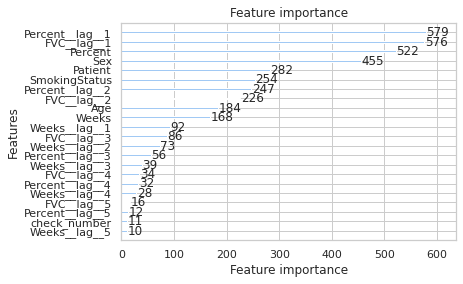

In [42]:
lgb.plot_importance(model)